# Segmentation

- If we want to use segmentation showing changes over time will be better to store as a table in the DB rather than recreating on each run!

In [14]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from utils import style
from sklearn.cluster import KMeans
from pywaffle import Waffle
import jenkspy
import numpy as np
import plotly.graph_objects as go
from kneed import KneeLocator

path = '/Users/jennamiles/Documents/credentials'

In [6]:
#this is from database.py
#need to update in utils because of directory issue
import os
from psycopg2 import connect
from pandas import read_sql

def query(sql_statement: str, **kwargs):
    with open(f'{path}', 'r') as credentials:
        connection = connect(credentials.read())
        cursor = connection.cursor()

        if len(kwargs) > 0:
            dataframe = read_sql(sql_statement.format(**kwargs), connection)
        else:
            dataframe = read_sql(sql_statement, connection)

        assert len(dataframe) > 0, 'query returned no results'
        return dataframe
    
def query_from_file(sql_file: str, **kwargs):
    with open(sql_file, 'r') as f:
        return query(f.read(), **kwargs)

In [7]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Vesterbro']
plt.rcParams['font.sans-serif'] = ['Akkurat Pro']
plt.rcParams['font.size'] = '15'

In [8]:
df = query_from_file('pure.sql')

In [9]:
df = df[['customer_id','total_amount','transaction_date','receipt_id']].drop_duplicates()

In [10]:
now = df['transaction_date'].max() + timedelta(days=1)
df['days_since_receipt'] = df['transaction_date'].apply(lambda x: (now - x).days)

In [11]:
period = 365 #will define the frequency and monetary value over this period

In [12]:
#recency and frequency  --> not sure this is the quickest way
aggr = {
    'days_since_receipt': lambda x: x.min(),  # the number of days since last order (recency)
    'transaction_date': lambda x: len([d for d in x if d >= now - timedelta(days=period)]), # the total number of orders in the last period (frequency)
}
rf = df.groupby('customer_id').agg(aggr).reset_index()
rf.rename(columns={'days_since_receipt': 'recency', 'transaction_date': 'frequency'}, inplace=True)

#monetary
monetary = (df[df['transaction_date'] >= now - timedelta(days=period)].groupby('customer_id').sum()['total_amount']/100).reset_index()
rfm = pd.merge(rf, monetary, on = 'customer_id', how = 'left').fillna(0)
rfm.columns = ['customer_id','recency','frequency','monetary']
rfm.head()

,customer_id,recency,frequency
0,00039533-dc80-4bd1-bc37-fab5ca4bd343,634,0
1,000cdac5-137c-4610-acf5-820e63c848a1,578,0
2,000ed711-2f2a-4070-97b5-554feec4a0ae,596,0
3,0016aba1-f401-49f5-bc44-8a19bdf0b4e0,447,0
4,001c79a3-196a-4207-8479-f87159a69574,687,0


- need to change the frequency calcaultion for last month so that only goes up to the last month
- might just be easier to create a subset dataframe

In [73]:
#get the metrics for last month 
last_month = df['transaction_date'].max() - timedelta(days=30)
df['days_since_receipt'] = df['transaction_date'].apply(lambda x: (last_month - x).days)

#recency and frequency  --> not sure this is the quickest way
aggr = {
    'days_since_receipt': lambda x: x.min(),  # the number of days since last order (recency)
    'transaction_date': lambda x: len([d for d in x if d >= last_month - timedelta(days=period)]), # the total number of orders in the last period (frequency)
}
rf = df.groupby('customer_id').agg(aggr).reset_index()
rf.rename(columns={'days_since_receipt': 'recency', 'transaction_date': 'frequency '}, inplace=True)
rf = rf[rf['recency']>=0]
#monetary
monetary = (df[(df['transaction_date'] >= last_month - timedelta(days=period))&(df['transaction_date'] <= last_month)].groupby('customer_id').sum()['total_amount']/100).reset_index()
rfm_last = pd.merge(rf, monetary, on = 'customer_id', how = 'left').fillna(0)
rfm_last.columns = ['customer_id','recency','frequency','monetary']
rfm_last.head()

,customer_id,recency,frequency,monetary
0,00039533-dc80-4bd1-bc37-fab5ca4bd343,603,0,0.0
1,000cdac5-137c-4610-acf5-820e63c848a1,547,0,0.0
2,000ed711-2f2a-4070-97b5-554feec4a0ae,565,0,0.0
3,0016aba1-f401-49f5-bc44-8a19bdf0b4e0,416,0,0.0
4,001c79a3-196a-4207-8479-f87159a69574,656,0,0.0


# Create the Jenks breaks
### This section should only be run once every year or period of time

- use elbow method to check what the optimal number of clusters
- going to set a minumum number of 4 so we guarantee some split among the variables 

In [793]:
cluster_numbers = pd.DataFrame()
for metric in ['recency','frequency','monetary']:
    inertia_results = []
    K = range(1,11)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(rfm[[metric]])
        inertia_results.append(kmeanModel.inertia_)

    kl = KneeLocator(range(1, 11), inertia_results, curve="convex", direction="decreasing")
    cluster_numbers = cluster_numbers.append(pd.DataFrame({'clusters': [kl.elbow]}, index = [metric]))

- use the jenks_breaks function to create the cutoff for each cluster

In [806]:
m_breaks = jenkspy.jenks_breaks(rfm['monetary'], nb_class=cluster_numbers.loc['monetary']['clusters'].item()) #item converts from numpy to native python
f_breaks = jenkspy.jenks_breaks(rfm['frequency'], nb_class=cluster_numbers.loc['frequency']['clusters'].item())
r_breaks = jenkspy.jenks_breaks(rfm['recency'], nb_class=cluster_numbers.loc['recency']['clusters'].item())

- create variables that hold the jenks r, f and m score
- create an overall score that combines r, f and m 

# Apply the Jenks breaks

- If these sit in database somewhere need importing

In [742]:
rfm['jenks_monetary'] = pd.cut(rfm['monetary'],bins=m_breaks,labels=[1,2,3,4],include_lowest=True)
rfm['jenks_frequency'] = pd.cut(rfm['frequency'],bins=f_breaks,labels=[1,2,3,4],include_lowest=True)
rfm['jenks_recency'] = pd.cut(rfm['recency'],bins=r_breaks,labels=[4,3,2,1],include_lowest=True)
rfm['RFM score jenks'] = rfm['jenks_recency'].astype(str) + rfm['jenks_frequency'].astype(str) + rfm['jenks_monetary'].astype(str)

#also do the same for results from previous month so we can show how customer have moved segments from previous month:
rfm_last['jenks_monetary'] = pd.cut(rfm_last['monetary'],bins=m_breaks,labels=[1,2,3,4],include_lowest=True)
rfm_last['jenks_frequency'] = pd.cut(rfm_last['frequency'],bins=f_breaks,labels=[1,2,3,4],include_lowest=True)
rfm_last['jenks_recency'] = pd.cut(rfm_last['recency'],bins=r_breaks,labels=[4,3,2,1],include_lowest=True)
rfm_last['RFM score jenks'] = rfm_last['jenks_recency'].astype(str) + rfm_last['jenks_frequency'].astype(str) + rfm_last['jenks_monetary'].astype(str)

# Plot the current distributions of R, F and M 
- make data avalilable in results_df1

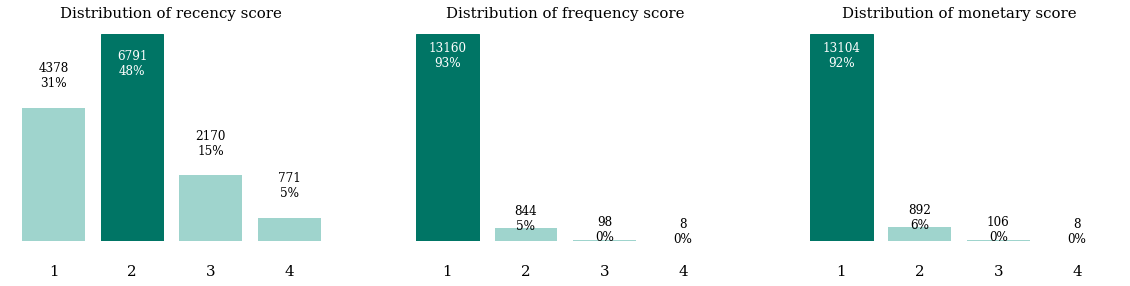

In [77]:
# plot the distribution of customers over R
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
from matplotlib.ticker import MaxNLocator

for i, p in enumerate(['jenks_recency','jenks_frequency','jenks_monetary']):
    parameters = {'jenks_recency':'recency','jenks_frequency':'frequency','jenks_monetary':'monetary'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='mint')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title('Distribution of {} score'.format(parameters[p]),
                fontsize=15)
    plt.setp(ax.get_xticklabels(), fontsize=15)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('green')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value - 500,
                    '{}\n{}%'.format(int(value), int(value * 100 / y.sum())),
                   ha='center',
                   va='top',
                   color='w',
                   size = 12)
        else :
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value + 1500,
                    '{}\n{}%'.format(int(value), int(value * 100 / y.sum())),
                   ha='center',
                   va='top',
                   color='black',
                   size = 12)
            


# RFM Combined segment

In [78]:
#map rfm score to segment names

segt_map = {
    
    #champions = top customers all round
    r'4[3-4][3-4]': 'Loyal: Champions',
    r'4[3-4][1-2]': 'Loyal: Bargain Hunters',
    r'4[1-2][1-2]': 'Newbies: Low value',
    r'4[1-2][3-4]': 'Newbies: Potential champions',
    
    #hibernators had their last transaction a long time ago 

    r'1[1-2][1-2]': 'Hibernating: Low value',
    r'1[1-2][3-4]': 'Hibernating: Whales',
    r'1[3-4][3-4]': 'Hibernating: Champions',    
    r'1[3-4][1-2]': 'Hibernating: Bargain Hunters',
    
    r'2[1-2][1-2]': 'Inactive: Low value',
    r'2[1-2][3-4]': 'Inactive: Whales',
    r'2[3-4][3-4]': 'Inactive: Champions',
    r'2[3-4][3-4]': 'Inactive: Bargain Hunters',
    
    r'3[1-2][1-2]': 'Active: Low Value',    
    r'3[1-2][3-4]': 'Active: Whales',
    r'3[3-4][3-4]': 'Active: Champions',
    r'3[3-4][1-2]': 'Active: Bargain Hunters',


}
rfm['segment'] = rfm['RFM score jenks'].replace(segt_map, regex=True)
rfm_last['segment'] = rfm_last['RFM score jenks'].replace(segt_map, regex=True)
rfm_plot_input = rfm.groupby('segment').nunique()['customer_id']
rfm_plot_input.index.values
pcents = rfm_plot_input.values/sum(rfm_plot_input.values)

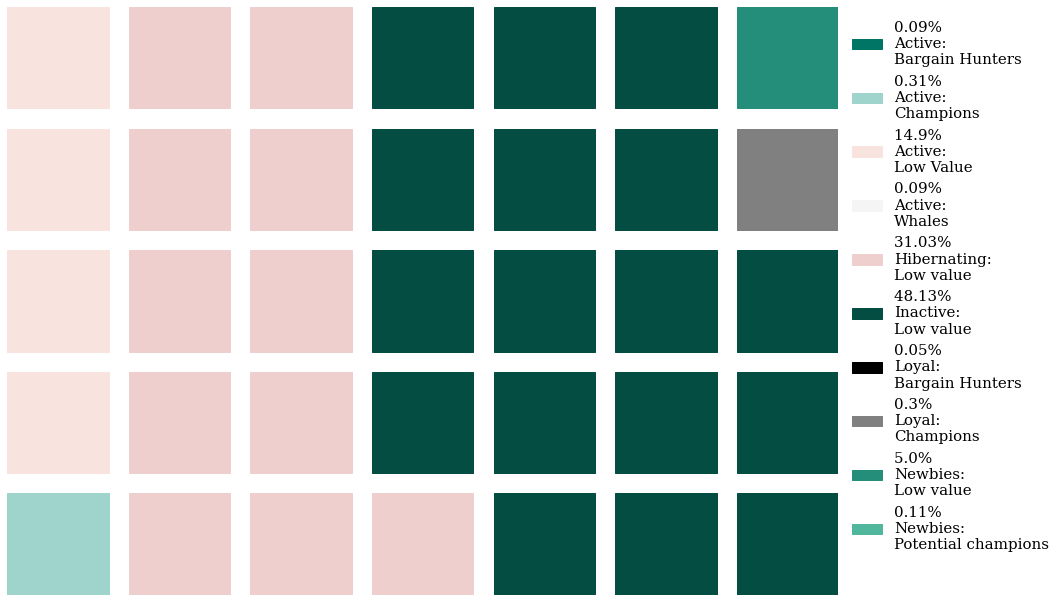

In [27]:
#sort out the labels to appear how we want 
wrapped_labels = [ label.replace(': ', ':\n') for label in rfm_plot_input.index.values ]
pcent_labels = []
for a in np.arange(len(wrapped_labels)):
    add = str(round(pcents[a]*100,2)) + '% \n' + wrapped_labels[a]
    pcent_labels.append(add)
    

fig = plt.figure(figsize=(15,12),
    FigureClass=Waffle,
    rows=5,
    columns=7,
    values=pd.Series(rfm_plot_input.values,index=pcent_labels).to_dict(),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1),'fontsize':15},
    colors=("green","mint", "pink","snow","chansey","tmnt","black","grey","merman", "sage")
)
plt.show()

# Change from previous month to this month
- Sankey will allow us to see where a customer group has moved from and to rather than just absolute volume changes

In [272]:
#merge jenks recency for the dataframes
rfm_recency = rfm[['customer_id','jenks_recency']]
rfm_recency_last = rfm_last[['customer_id','jenks_recency']]

#change merge to outer to allow for nulls in both
#then want to fill with 0 or something so we can identify new customers coming in 
recency_change = pd.merge(rfm_recency,rfm_recency_last, on = 'customer_id',how = 'left')
recency_change.fillna(0, inplace = True)

recency_change_vols = recency_change.groupby(['jenks_recency_y','jenks_recency_x']).nunique().reset_index()

recency_change_vols.columns = ['last month','this month','value']
recency_change_vols

,last month,this month,value
0,0.0,4,697
1,1.0,1,3547
2,2.0,1,831
3,2.0,2,6791
4,3.0,3,2170
5,4.0,4,74


In [267]:
new_source =  pd.DataFrame(data = recency_change_vols['last month'].drop_duplicates().index.values).reset_index()
new_source.columns = ['last month','new last month']
new_target=  pd.DataFrame(data = recency_change_vols['this month'].drop_duplicates()).reset_index()
new_target['new this month'] = new_target['index']+recency_change_vols['this month'].index.max()+1
recency_change_vols = pd.merge(recency_change_vols,new_source,on='last month',how ='left')
recency_change_vols = pd.merge(recency_change_vols,new_target[['this month','new this month']],on='this month',how ='left')

In [269]:
colour_map = {
    0.0: "white",
    1.0: "#9FD4CD",
    2.0 :"#EECFCE",
    3.0: "#121212",
    4.0: "#248E7A",
}
rcolours = list(recency_change_vols['last month'].append(recency_change_vols['this month']).replace(colour_map))

In [270]:
label_map = {
    0.0: "Acquired",
    1.0: "Hibernating",
    2.0 :"Inactive",
    3.0: "Active",
    4.0: "Recent",
}
rlabels = list(recency_change_vols['last month'].append(recency_change_vols['this month']).replace(label_map))

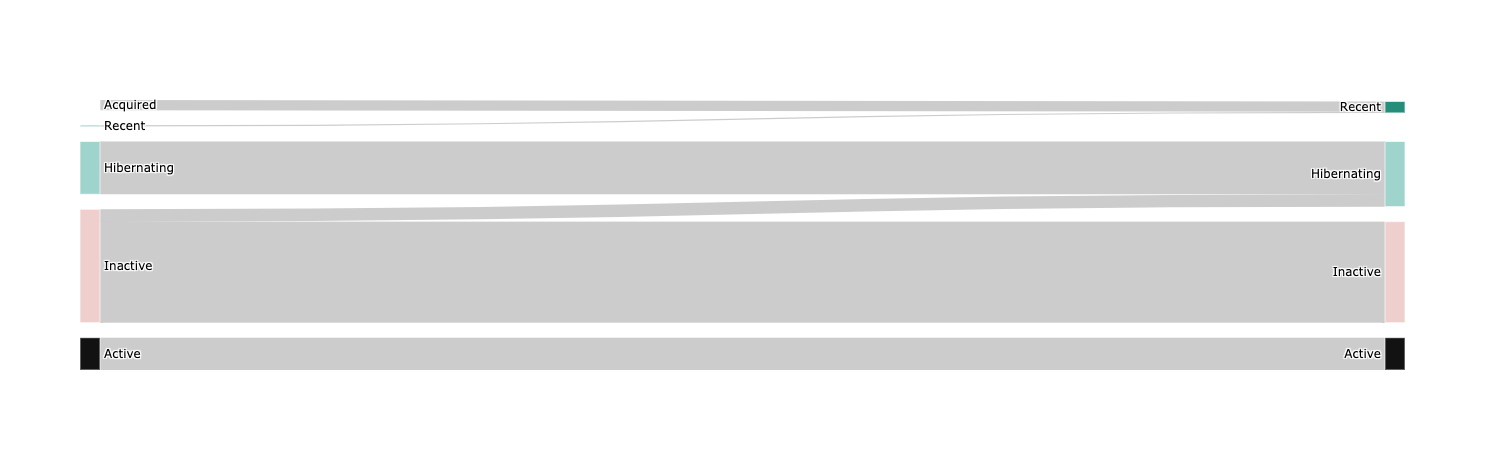

In [271]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "white", width = 0.5),
      label = rlabels, 
      color = rcolours
    ),
    link = dict(
      source = list(recency_change_vols['new last month']), #these are the first index locations rather than the source number --> this is because it need st to use the iundex to find the right value
      target = list(recency_change_vols['new this month']), #these are the min index locations too but of what should appear on the right hand side
      value =  recency_change_vols['value']
  ))])
fig.show()

- Try sankey for all segments

In [323]:
#merge jenks recency for the dataframes
rfm_segment = rfm[['customer_id','segment']]
rfm_segment_last = rfm_last[['customer_id','segment']]

#change merge to outer to allow for nulls in both
#then want to fill with 0 or something so we can identify new customers coming in 
segment_change = pd.merge(rfm_segment,rfm_segment_last, on = 'customer_id',how = 'left')
segment_change.fillna('Acquired', inplace = True)

segment_change_vols = segment_change.groupby(['segment_y','segment_x']).nunique().reset_index()
segment_change_vols.columns = ['last month','this month','value']
segment_change_vols

,last month,this month,value
0,Acquired,Loyal: Bargain Hunters,6
1,Acquired,Loyal: Champions,41
2,Acquired,Newbies: Low value,635
3,Acquired,Newbies: Potential champions,15
4,Active: Bargain Hunters,Active: Bargain Hunters,12
5,Active: Champions,Active: Champions,44
6,Active: Low Value,Active: Low Value,2102
7,Active: Whales,Active: Whales,12
8,Hibernating: Low value,Hibernating: Low value,3547
9,Inactive: Low value,Hibernating: Low value,831


In [324]:
new_source =  pd.DataFrame(data = segment_change_vols['last month'].drop_duplicates().index.values)
new_source['last month']= segment_change_vols['last month'].unique()
new_source.columns = ['new last month','last month']
segment_change_vols = pd.merge(segment_change_vols,new_source,on='last month',how ='left')
new_target = pd.DataFrame(data = segment_change_vols['this month'].drop_duplicates().index.values)+segment_change_vols['this month'].index.max()+1
new_target['this month']= segment_change_vols['this month'].unique()
new_target.columns = ['new this month','this month']
segment_change_vols = pd.merge(segment_change_vols,new_target[['this month','new this month']],on='this month',how ='left')
segment_change_vols

In [360]:
segment_change_vols

,last month,this month,value,new last month,new this month
0,Acquired,Loyal: Bargain Hunters,6,0,14
1,Acquired,Loyal: Champions,41,0,15
2,Acquired,Newbies: Low value,635,0,16
3,Acquired,Newbies: Potential champions,15,0,17
4,Active: Bargain Hunters,Active: Bargain Hunters,12,4,18
5,Active: Champions,Active: Champions,44,5,19
6,Active: Low Value,Active: Low Value,2102,6,20
7,Active: Whales,Active: Whales,12,7,21
8,Hibernating: Low value,Hibernating: Low value,3547,8,22
9,Inactive: Low value,Hibernating: Low value,831,9,22


In [351]:
colour_map = {
    "Acquired": "pink",
    "Active: Bargain Hunters": "#9FD4CD",
    "Active: Champions" :"#EECFCE",
    "Active: Low Value": "#121212",
    "Active: Whales": "#248E7A",
    "Hibernating: Low value": "white",
    "Inactive: Low value": "#9FD4CD",
    "Loyal: Bargain Hunters" :"#EECFCE",
    "Loyal: Champions": "#121212",
    "Newbies: Low value": "#248E7A", 
    "Newbies: Potential champions": "black",    
}
rcolours = list(segment_change_vols['last month'].append(segment_change_vols['this month']).replace(colour_map))
rlabels = list(segment_change_vols['last month'].append(segment_change_vols['this month']))

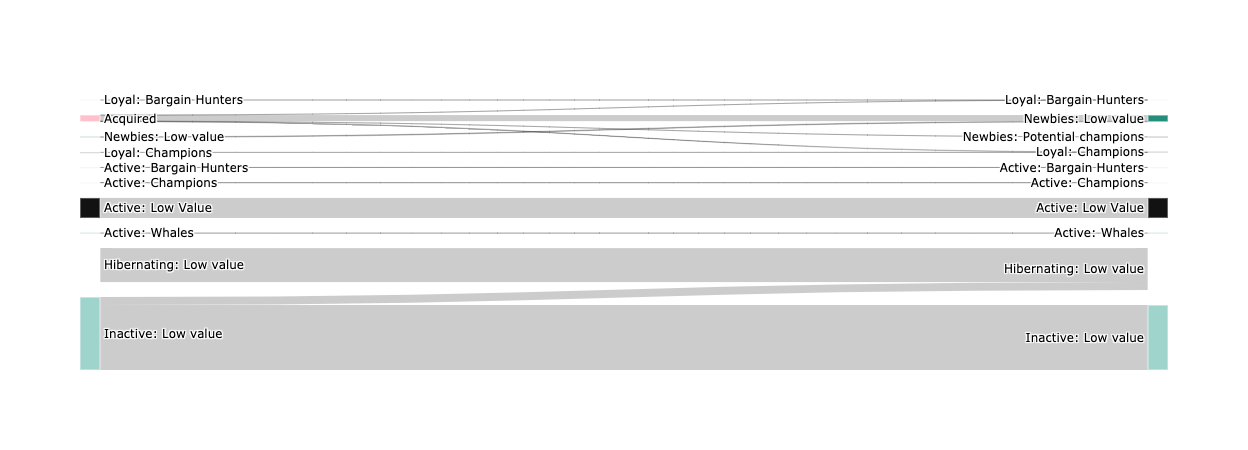

In [355]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "white", width = 0.5),
      label = rlabels, 
      color = rcolours
    ),
    link = dict(
      source = list(segment_change_vols['new last month']), #these are the first index locations rather than the source number --> this is because it need st to use the iundex to find the right value
      target = list(segment_change_vols['new this month']), #these are the min index locations too but of what should appear on the right hand side
      value =  segment_change_vols['value']
  ))])
fig.show()

In [367]:
#what if we only display the things that have changed?
segment_change_vols_subset = segment_change_vols[segment_change_vols['last month']!=segment_change_vols['this month']]
segment_change_vols_subset

,last month,this month,value,new last month,new this month
0,Acquired,Loyal: Bargain Hunters,6,0,14
1,Acquired,Loyal: Champions,41,0,15
2,Acquired,Newbies: Low value,635,0,16
3,Acquired,Newbies: Potential champions,15,0,17
9,Inactive: Low value,Hibernating: Low value,831,9,22


In [369]:

segment_change_vols_subset = segment_change_vols_subset.drop(['new last month','new this month'],axis = 1).reset_index()
new_source =  pd.DataFrame(data = segment_change_vols_subset['last month'].drop_duplicates().index.values)
new_source['last month']= segment_change_vols_subset['last month'].unique()
new_source.columns = ['new last month','last month']
segment_change_vols_subset = pd.merge(segment_change_vols_subset,new_source,on='last month',how ='left')


new_target = pd.DataFrame(data = segment_change_vols_subset['this month'].drop_duplicates().index.values)+segment_change_vols_subset['this month'].index.max()+1
new_target['this month']= segment_change_vols_subset['this month'].unique()
new_target.columns = ['new this month','this month']
segment_change_vols_subset = pd.merge(segment_change_vols_subset,new_target[['this month','new this month']],on='this month',how ='left')
segment_change_vols_subset


,index,last month,this month,value,new last month,new this month
0,0,Acquired,Loyal: Bargain Hunters,6,0,5
1,1,Acquired,Loyal: Champions,41,0,6
2,2,Acquired,Newbies: Low value,635,0,7
3,3,Acquired,Newbies: Potential champions,15,0,8
4,4,Inactive: Low value,Hibernating: Low value,831,4,9


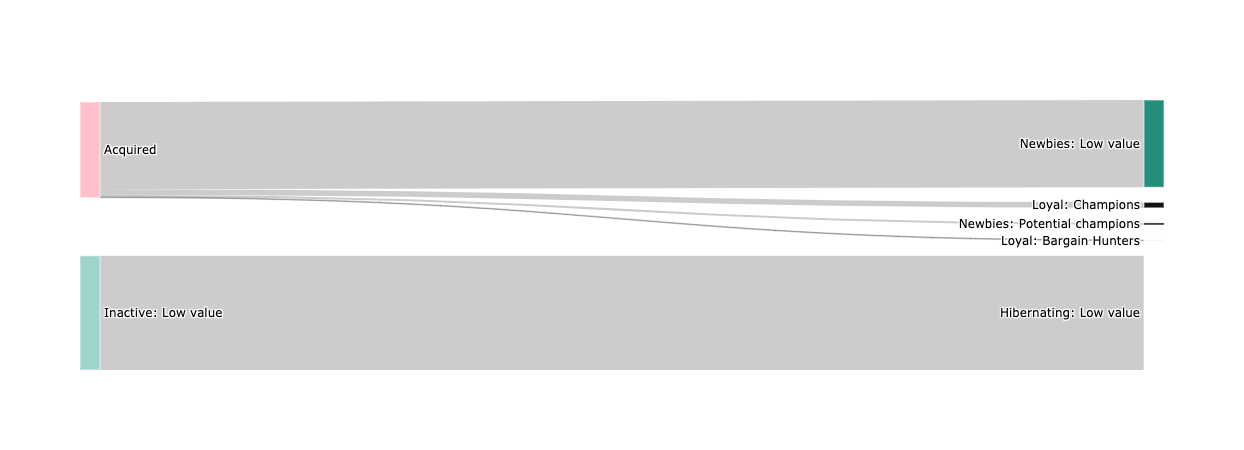

In [370]:

rcolours = list(segment_change_vols_subset['last month'].append(segment_change_vols_subset['this month']).replace(colour_map))
rlabels = list(segment_change_vols_subset['last month'].append(segment_change_vols_subset['this month']))

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "white", width = 0.5),
      label = rlabels, 
      color = rcolours
    ),
    link = dict(
      source = list(segment_change_vols_subset['new last month']), #these are the first index locations rather than the source number --> this is because it need st to use the iundex to find the right value
      target = list(segment_change_vols_subset['new this month']), #these are the min index locations too but of what should appear on the right hand side
      value =  segment_change_vols_subset['value']
  ))])
fig.show()


# Change over time 
Dataframes:
- recency
- frequency
- monetary
- recency_pcent
- frequency_pcent
- monetary_pcent

In [808]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *
cal_end = datetime.now().replace(day=1).date()
calendar = sorted([cal_end + relativedelta(months=-c) for c in np.arange(7)])

In [815]:
r

,customer_id,days_since_receipt
0,00039533-dc80-4bd1-bc37-fab5ca4bd343,1
1,000cdac5-137c-4610-acf5-820e63c848a1,2
2,000ed711-2f2a-4070-97b5-554feec4a0ae,2
3,0016aba1-f401-49f5-bc44-8a19bdf0b4e0,2
4,001c79a3-196a-4207-8479-f87159a69574,1
...,...,...
13816,ffedc790-c615-4e7c-a333-08367cb9e426,2
13817,fff15e67-5ad3-46eb-b636-082cd10b24ec,2
13818,fff460ad-5bf4-464f-8d6a-1904bb404207,1
13819,fffa6c13-7fb0-45ed-946f-49444311d6d6,3


In [838]:
df_rf = pd.merge(r,f,on = 'customer_id',how = 'left').fillna(0)
df_rfm = pd.merge(df_rf,m,on = 'customer_id',how = 'left').fillna(0)
df_rfm.columns = ['customer_id','recency','frequency','monetary']
df_rfm['RFM score jenks'] = df_rfm['recency'].astype(int).astype(str) + df_rfm['frequency'].astype(int).astype(str) + df_rfm['monetary'].astype(int).astype(str)
df_rfm['segment'] = df_rfm['RFM score jenks'].replace(segt_map, regex=True)
rfm_counts = pd.DataFrame(df_rfm.groupby('segment').nunique()['customer_id']).reset_index()
rfm_counts['month'] = date2
segments=segments.append(rfm_counts)         


rfm_counts.head()


RFM score jenks
100    3571
200    7722
311    1440
312     171
321     152
Name: customer_id, dtype: int64

,segment,customer_id
0,100,3571
1,200,7722
2,Active: Bargain Hunters,16
3,Active: Champions,58
4,Active: Low Value,2243
5,Active: Whales,21
6,Loyal: Bargain Hunters,3
7,Loyal: Champions,16
8,Newbies: Low value,169
9,Newbies: Potential champions,2


In [845]:
#loop through month starts going back 6 months 
#assign the RFM segments 
frequency = pd.DataFrame()
monetary = pd.DataFrame()
recency = pd.DataFrame()
segments = pd.DataFrame()

for date2 in calendar:
    date1 = date2 + relativedelta(months = -12)
    df_period = df[(df['transaction_date'].dt.date >=date1) & (df['transaction_date'].dt.date<date2)].copy()
    df_recency_period = df[df['transaction_date'].dt.date < date2].copy()
    df_period['days_since_receipt'] = df_period['transaction_date'].dt.date.apply(lambda x: (date2 - x).days)
    #frequency
    f = df_period.groupby('customer_id').nunique()['receipt_id'].apply(lambda x: jenks_frequency(x)).reset_index()
    f_counts = f.groupby('receipt_id').nunique()['customer_id']
    frequency=frequency.append(f_counts.T)
    #monetary
    m = (df_period.groupby('customer_id').sum()['total_amount']/100).apply(lambda x: jenks_monetary(x)).reset_index()
    m_counts = m.groupby('total_amount').nunique()['customer_id']
    monetary=monetary.append(m_counts.T)    
    #recency 
    r = df_recency_period.groupby('customer_id').min()['days_since_receipt'].apply(lambda x: jenks_recency(x)).reset_index()
    r_counts = r.groupby('days_since_receipt').nunique()['customer_id']
    recency=recency.append(r_counts.T)
    #full segments
    df_rf = pd.merge(r,f,on = 'customer_id',how = 'left').fillna(0)
    df_rfm = pd.merge(df_rf,m,on = 'customer_id',how = 'left').fillna(0)
    df_rfm.columns = ['customer_id','recency','frequency','monetary']
    df_rfm['RFM score jenks'] = df_rfm['recency'].astype(int).astype(str) + df_rfm['frequency'].astype(int).astype(str) + df_rfm['monetary'].astype(int).astype(str)
    df_rfm['segment'] = df_rfm['RFM score jenks'].replace(segt_map, regex=True)
    rfm_counts = pd.DataFrame(df_rfm.groupby('segment').nunique()['customer_id']).reset_index()
    rfm_counts['month'] = date2
    segments=segments.append(rfm_counts)   
    

frequency.fillna(0,inplace = True)
frequency.index = calendar
if 5 in frequency.columns:
    frequency['4'] = frequency[4]+frequency[5] #for previous months there is the chance that the frequency could be greater than breaks set
    frequency = frequency[[1,2,3,'4']]
frequency.columns = ['Low','Medium','High','Very High']

monetary.fillna(0,inplace = True)
monetary.index = calendar
if 5 in monetary.columns:
    monetary['4'] = monetary[4]+monetary[5] #for previous months there is the chance that the frequency could be greater than breaks set
    monetary = monetary[[1,2,3,'4']]
monetary.columns = ['Low','Medium','High','Very High']

recency.fillna(0,inplace = True)
recency.index = calendar
if 5 in recency.columns:
    recency['4'] = recency[4]+recency[5] #for previous months there is the chance that the frequency could be greater than breaks set
    recency = recency[[1,2,3,'4']]
recency.columns = ['Hibernating','Inactive','Active','Recent']



In [846]:
segments

,segment,customer_id,month
0,100,3607,2020-10-01
1,200,896,2020-10-01
2,231,1,2020-10-01
3,232,92,2020-10-01
4,245,5,2020-10-01
...,...,...,...
5,Active: Whales,21,2021-04-01
6,Loyal: Bargain Hunters,3,2021-04-01
7,Loyal: Champions,16,2021-04-01
8,Newbies: Low value,169,2021-04-01


In [712]:
recency

,Hibernating,Inactive,Active,Recent
2020-10-01,3607.0,7958.0,1814.0,0.0
2020-11-01,3578.0,7781.0,2354.0,0.0
2020-12-01,3578.0,7757.0,2404.0,0.0
2021-01-01,3578.0,7757.0,2404.0,0.0
2021-02-01,3578.0,7757.0,2404.0,0.0
2021-03-01,3578.0,7757.0,2404.0,0.0
2021-04-01,3571.0,7722.0,2338.0,190.0


In [714]:
frequency

,Low,Medium,High,Very High
2020-10-01,4746.0,3242.0,742.0,146.0
2020-11-01,4545.0,3014.0,648.0,114.0
2020-12-01,4095.0,2629.0,533.0,67.0
2021-01-01,3712.0,2332.0,412.0,48.0
2021-02-01,3109.0,1863.0,262.0,19.0
2021-03-01,2381.0,1209.0,114.0,12.0
2021-04-01,1722.0,713.0,85.0,8.0


In [716]:
monetary

,Low,Medium,High,Very High
2020-10-01,4913.0,3055.0,753.0,155.0
2020-11-01,4689.0,2894.0,625.0,113.0
2020-12-01,4194.0,2553.0,500.0,77.0
2021-01-01,3790.0,2245.0,425.0,44.0
2021-02-01,3184.0,1796.0,256.0,17.0
2021-03-01,2395.0,1195.0,113.0,13.0
2021-04-01,1686.0,745.0,89.0,8.0


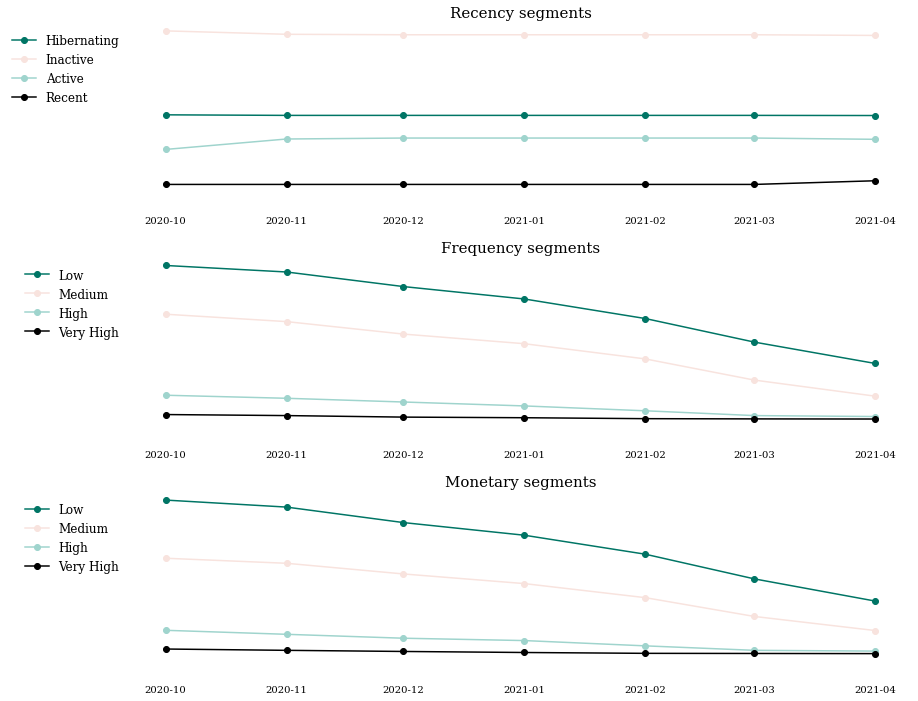

In [713]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (13,10))

rfm_object = [recency,frequency,monetary]
rfm_names = ['Recency','Frequency','Monetary']
for i in [0,1,2]:
    ax = axes[i]
    metric_labels = rfm_object[i].columns
    ax.plot(rfm_object[i].index.values,rfm_object[i][metric_labels[0]],marker = '.', markersize = 12, label = metric_labels[0])
    ax.plot(rfm_object[i].index.values,rfm_object[i][metric_labels[1]],marker = '.', markersize = 12, label = metric_labels[1])
    ax.plot(rfm_object[i].index.values,rfm_object[i][metric_labels[2]],marker = '.', markersize = 12,label = metric_labels[2])
    ax.plot(rfm_object[i].index.values,rfm_object[i][metric_labels[3]],marker = '.', markersize = 12, label = metric_labels[3], color = 'black')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.legend(fontsize= 12, bbox_to_anchor=(0,1))
    ax.set_title(rfm_names[i]+' segments',fontsize=15)
plt.tight_layout()
plt.show()

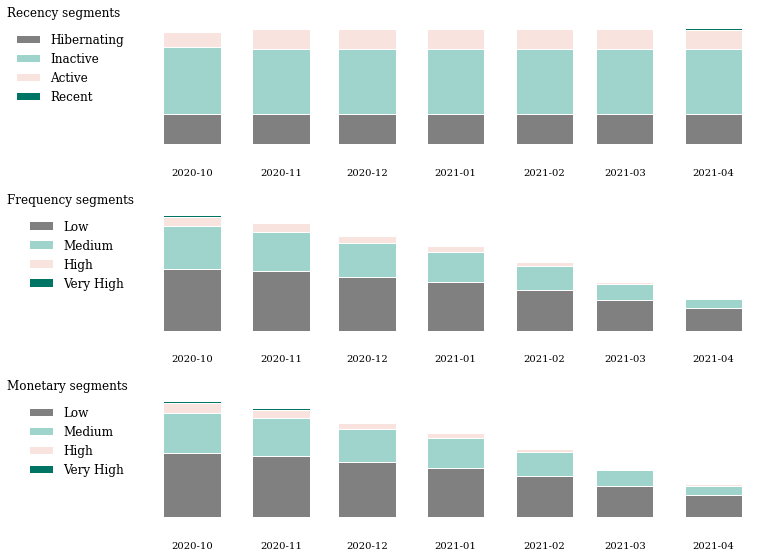

In [719]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (11,8))

rfm_object = [recency,frequency,monetary]
rfm_names = ['Recency','Frequency','Monetary']
for i in [0,1,2]:
    ax = axes[i]
    metric_labels = rfm_object[i].columns

    # Values of each group
    bars1 = rfm_object[i][metric_labels[0]].values
    bars2 = rfm_object[i][metric_labels[1]].values
    bars3 = rfm_object[i][metric_labels[2]].values
    bars4 = rfm_object[i][metric_labels[3]].values
        
    # Heights of bars1 + bars2
    bars12 = np.add(bars1, bars2).tolist()
    bars123 = np.add(bars12,bars3).tolist()
 
    # The position of the bars on the x-axis
    r = list(rfm_object[i].index.values)
 
    # Names of group and bar width
    barWidth = 20
 
    ax.bar(r, bars1, color='grey', edgecolor='white', width=barWidth, label = metric_labels[0])
    ax.bar(r, bars2, bottom=bars1, color='mint', edgecolor='white', width=barWidth, label = metric_labels[1])
    ax.bar(r, bars3, bottom=bars12, color='pink', edgecolor='white', width=barWidth, label = metric_labels[2])
    ax.bar(r, bars4, bottom=bars123, color='green', edgecolor='white', width=barWidth, label = metric_labels[3])
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.legend(fontsize= 12, bbox_to_anchor=(0,1))
    ax.set_title(rfm_names[i]+' segments',fontsize=12,loc='left',x = (-0.2))
    
plt.tight_layout()
plt.show()

In [722]:
monetary_pcent= monetary.div(monetary.sum(axis=1), axis=0)
recency_pcent= recency.div(recency.sum(axis=1), axis=0)
frequency_pcent= frequency.div(monetary.sum(axis=1), axis=0)

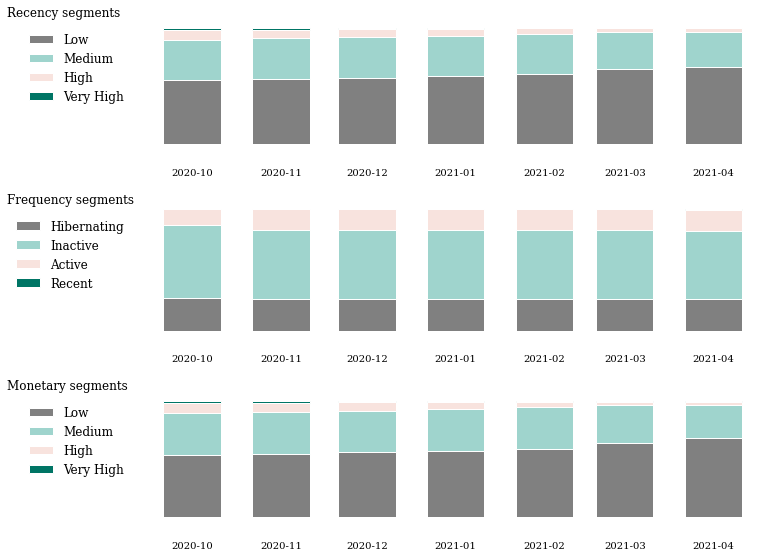

In [723]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (11,8))

rfm_object = [monetary_pcent,recency_pcent,frequency_pcent]
rfm_names = ['Recency','Frequency','Monetary']
for i in [0,1,2]:
    ax = axes[i]
    metric_labels = rfm_object[i].columns

    # Values of each group
    bars1 = rfm_object[i][metric_labels[0]].values
    bars2 = rfm_object[i][metric_labels[1]].values
    bars3 = rfm_object[i][metric_labels[2]].values
    bars4 = rfm_object[i][metric_labels[3]].values
        
    # Heights of bars1 + bars2
    bars12 = np.add(bars1, bars2).tolist()
    bars123 = np.add(bars12,bars3).tolist()
 
    # The position of the bars on the x-axis
    r = list(rfm_object[i].index.values)
 
    # Names of group and bar width
    barWidth = 20
 
    ax.bar(r, bars1, color='grey', edgecolor='white', width=barWidth, label = metric_labels[0])
    ax.bar(r, bars2, bottom=bars1, color='mint', edgecolor='white', width=barWidth, label = metric_labels[1])
    ax.bar(r, bars3, bottom=bars12, color='pink', edgecolor='white', width=barWidth, label = metric_labels[2])
    ax.bar(r, bars4, bottom=bars123, color='green', edgecolor='white', width=barWidth, label = metric_labels[3])
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.legend(fontsize= 12, bbox_to_anchor=(0,1))
    ax.set_title(rfm_names[i]+' segments',fontsize=12,loc='left',x = (-0.2))
    
plt.tight_layout()
plt.show()

- plot all segments change over time 

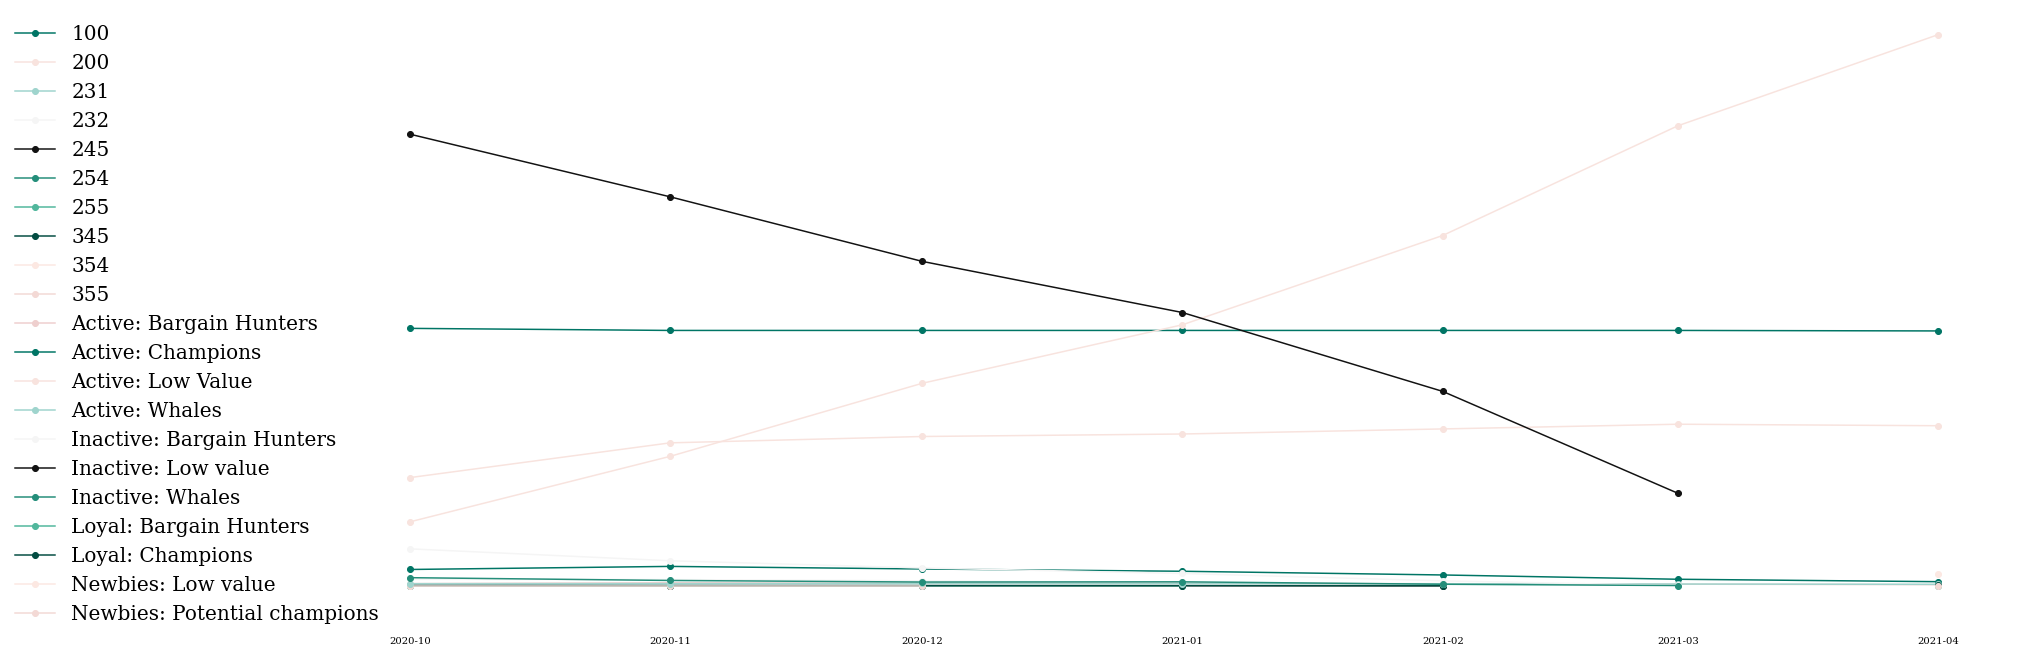

In [883]:
fig, ax = plt.subplots(1,figsize = (28,10))
for s in segments.segment.unique():
    input_data = segments[segments.segment == s]
    ax.plot(input_data.month, input_data.customer_id, label = s, marker = 'o')
    ax.set_frame_on(False)
ax.tick_params(left=False, labelleft=False, bottom=False)
ax.legend(loc = 'upper left', bbox_to_anchor=(-0.2,1))
plt.tight_layout()

In [ ]:
#think its too difficult to interpret all the segments on a graph over time
#maybe just a % change from previous month or rolling months 

In [884]:
import plotly.express as px

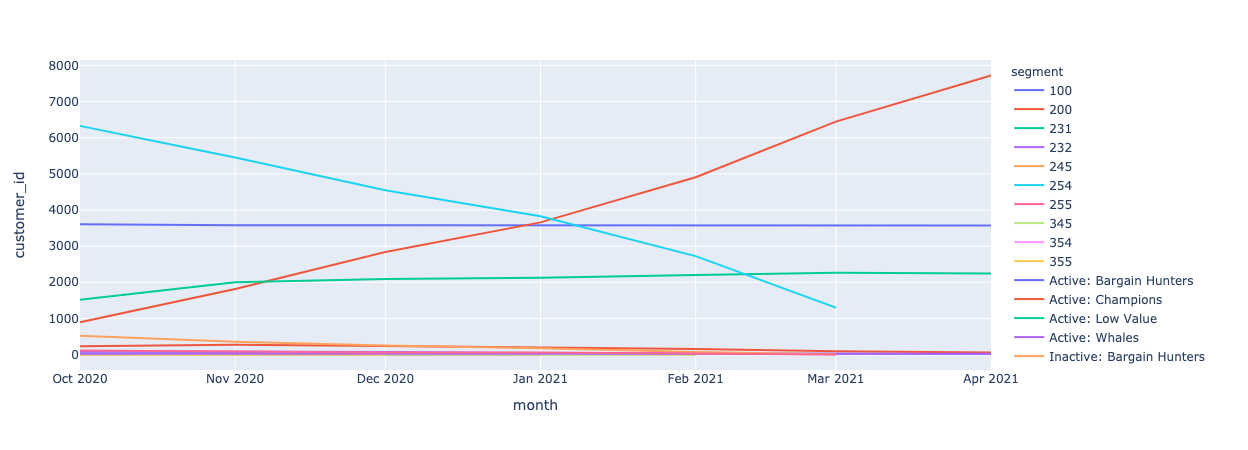

In [885]:
df = segments
fig = px.line(df, x="month", y="customer_id", color='segment')
fig.show()